<a href="https://colab.research.google.com/github/julichitai/learning_NN/blob/MIPT/mipt_%5Bseminar%5Dobject_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

https://bit.ly/2QxD8ef

https://www.youtube.com/watch?v=xHIzyrU1uVM&t=1050s

---

<h2 style="text-align: center;"><b>Детектирование объектов с помощью нейросетей</b></h2>

---

<img src="https://rossmelbourne.com/wp-content/uploads/2018/09/Object-Detection.png">

<h4 style="text-align: center;"><b>Составитель: Илья Захаркин (ФИВТ МФТИ, NeurusLab). По всем вопросам в Telegram: <a>@ilyazakharkin</a></b></h4>

---

Всем привет! Давайте узнаем, как с помощью различных нейросеток детектировать объекты на картинках. Мы рассмотрим три основные архитектуры, которые используются в detection'е: **Faster-RCNN**, **SSD** и **YOLO**. А именно, сейчас наиболее популярны **Mask-RCNN**, **SSD с MobileNet backbone'ом** и **YOLOv3**. Мы не будем слишком сильно углубляться в подробности, все полезные ссылки будут приведены в конце и по ходу ноутбука.  

Цель этого занятия -- научить вас использовать SSD, Mask-RCNN и YOLOv3 для детектирования объектов на изображениях и заложить основу понимая того, как и почему работают детекторы.

<h3 style="text-align: center;"><b>Примеры</b></h3>

Мы хотим научиться делать примерно так:

<img src="http://chaosmail.github.io/images/deep-learning/recognition.png" width=450 height=300>
<img src="http://www.thesis123.com/wp-content/uploads/2018/08/C2iLN6iW8AEbk5D.jpg" width=450 height=300>

Кстати, Mask-RCNN и вовсе умеет детектировать объекты вместе с их масками (прямо как в фильме "Терминатор"!)

<img src="https://i.ytimg.com/vi/OOT3UIXZztE/maxresdefault.jpg" width=450 height=250>
<img src="https://cdn.igromania.ru/mnt/news/1/b/0/1/8/e/55545/5717f7ef43d7419e_1200xH.jpg" width=450 height=250>

 <h2 style="text-align: center;"><b>Основная идея нейросетевых детекторов</b></h2>

* В *задаче классификации* мы пропускали картинку через нейросеть и получали на выходе $K$ чисел -- вероятности принадлежности к каждому из $K$ классов
* В *задаче сегментации* мы получали на выходе маску классов, то есть картинку $(H, W, K)$, где $K$ -- это количество классов в задаче сегментации, где каждый канал масок отвечает за один класс объектов), а $H$ и $W$ -- высота и ширина изначальной поданной на вход картинки
* В *задаче детектирования* мы хотим получить на выходе набор из "прямоугольников" (обычно их называют **bounding box**'ы, или просто **box**'ы), каждый из которых принадлежит определённому классу с некоторой вероятностью (см. картинку ниже). 

Для задачи детектирования точно так же нужно **заранее знать количество классов**, чтобы мы знали, сколько в принципе есть классов объектов. Однако остаётся другая проблема -- как узнать, скоько именно объектов на изображении? Нам ведь нужно как-то обучать нашу нейросеть, то есть подавать 

<img src="https://cdn.cognitiveseo.com/blog/wp-content/uploads/2014/09/automatic-object-detection-images-google.jpg" width=500 height=400>

Идея в том, чтобы решать задачу регрессии при уточнении координат углов bbox'ов и одновременно решать задачу классификации внутри этих bbox'ов. Соответственно, для регрессии координат будет использовать один тип loss'а, а для классификации -- другой. Чтобы обучать нейросеть и на то, и на то, лоссы складываются с определёнными коэффициентами, но об этом позже.

<h2 style="text-align: center;"><b>Сразу в бой!</b></h2>

Давайте сразу посмотрим на то, как работает детектор -- запустим его своими руками.

На данный момент код детекторов пишется преимущественно на TensorFlow, а именно -- есть такая прекрасная вещь, как TensorFlow Object Detection API: https://github.com/tensorflow/models/tree/master/research/object_detection

Давайте проверим, есть ли у нас tf и его версию:

In [ ]:
# !pip install tensorflow-gpu==1.15

In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

2.4.0


In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1850266627138141939, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2004505337842095381
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

### Краткое введение в TensorFlow

<img src="https://cdn-images-1.medium.com/max/1600/1*eFRgat2Iy6wZpi_DEItKgA.png" width=300 height=200>

Давайте познакомимся с TensorFlow -- очень популярным и многофункциональным фреймворком глубокого обучения.

В TF есть две основные сущности -- это ***граф вычислений (`tf.Graph()`)*** и ***сессия (`tf.Session()`)***.

Сначала *строится* граф вычислений, а потом в сессии он *исполняется*.

Пример графа вычислений (очень условный):

<img src="https://camo.qiitausercontent.com/137bc298bf30fe06e61b59a638fea966d272f2b8/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f313034362f38663430386438392d666563362d643761632d633961662d3865393061383039613233622e706e67" width=300 height=400>

А вот пример реального графа (скрин из TensorBoard):

<img src="https://blog.altoros.com/wp-content/uploads/2016/05/visualizing-graphs-with-tensorboard-wxb-group.png">

То есть граф -- то нечто построенное нами до сессии, а сессия -- это то, во время чего все операции в графе исполняются (при подаче в него входных данных). Пока что это всё, что нам нужно знать, чтобы понять код для запуска детектора из TF ObjDet API.

КРАЙНЕ советую пройти самостоятельно следующие мини-курсы по TF:
* Начать с официального intro: https://www.tensorflow.org/guide/low_level_intro 
* Продолжить этими замечательными практикумами: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd
* Посмотреть что-то здесь, если не очень понятно: https://github.com/Hvass-Labs/TensorFlow-Tutorials
* Закончить продвинутым курсом: https://github.com/sjchoi86/advanced-tensorflow

И не забудьте заглянуть в официальные туториалы: https://www.tensorflow.org/tutorials/

Это будет очень и очень полезно, если вы собираетесь заниматься deep learning'ом в "реальной жизни", уметь читать сложный код и прокачиваться в нейросетках.

[Установим TF ObjDet API на Google Colab](https://stackoverflow.com/questions/48663207/colaboratory-install-tensorflow-object-detection-api):

In [4]:
!apt-get install -y -qq protobuf-compiler python-pil python-lxml
!pip install --user Cython
!pip install --user contextlib2
!pip install --user jupyter
!pip install --user matplotlib

Selecting previously unselected package python-bs4.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [5]:
!git clone --quiet https://github.com/tensorflow/models.git

In [6]:
!ls

models	sample_data


In [7]:
import os
os.chdir('models/research')

In [8]:
!ls

a3c_blogpost	    cvt_text	   lstm_object_detection  rebar
adversarial_text    deeplab	   marco		  seq_flow_lite
attention_ocr	    deep_speech    nst_blogpost		  setup.py
audioset	    delf	   object_detection	  slim
autoaugment	    efficient-hrl  pcl_rl		  vid2depth
cognitive_planning  lfads	   README.md


In [9]:
!protoc object_detection/protos/*.proto --python_out=.

In [10]:
import sys
sys.path.append('/content/models/research/slim')

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
!pip install tf_slim

     |████████████████████████████████| 358kB 21.8MB/s 


In [ ]:
%run object_detection/builders/model_builder_test.py

AttributeError: ignored

Давайте воспроизведём их туториал:

In [13]:
os.chdir('./object_detection')

In [14]:
!ls

anchor_generators			 inference
box_coders				 __init__.py
builders				 inputs.py
colab_tutorials				 inputs_test.py
configs					 legacy
CONTRIBUTING.md				 matchers
core					 meta_architectures
data					 metrics
data_decoders				 model_hparams.py
dataset_tools				 model_lib.py
dockerfiles				 model_lib_tf1_test.py
eval_util.py				 model_lib_tf2_test.py
eval_util_test.py			 model_lib_v2.py
exporter_lib_tf2_test.py		 model_main.py
exporter_lib_v2.py			 model_main_tf2.py
exporter_main_v2.py			 models
exporter.py				 model_tpu_main.py
exporter_tf1_test.py			 packages
export_inference_graph.py		 predictors
export_tflite_graph_lib_tf2.py		 protos
export_tflite_graph_lib_tf2_test.py	 README.md
export_tflite_graph_tf2.py		 samples
export_tflite_ssd_graph_lib.py		 test_data
export_tflite_ssd_graph_lib_tf1_test.py  test_images
export_tflite_ssd_graph.py		 tpu_exporters
g3doc					 utils


https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

In [15]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

In [16]:
# This is needed to display the images.
%matplotlib inline

In [17]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [18]:
!ls

anchor_generators			 __init__.py
box_coders				 inputs.py
builders				 inputs_test.py
colab_tutorials				 legacy
configs					 matchers
CONTRIBUTING.md				 meta_architectures
core					 metrics
data					 model_hparams.py
data_decoders				 model_lib.py
dataset_tools				 model_lib_tf1_test.py
dockerfiles				 model_lib_tf2_test.py
eval_util.py				 model_lib_v2.py
eval_util_test.py			 model_main.py
exporter_lib_tf2_test.py		 model_main_tf2.py
exporter_lib_v2.py			 models
exporter_main_v2.py			 model_tpu_main.py
exporter.py				 packages
exporter_tf1_test.py			 predictors
export_inference_graph.py		 protos
export_tflite_graph_lib_tf2.py		 __pycache__
export_tflite_graph_lib_tf2_test.py	 README.md
export_tflite_graph_tf2.py		 samples
export_tflite_ssd_graph_lib.py		 test_data
export_tflite_ssd_graph_lib_tf1_test.py  test_images
export_tflite_ssd_graph.py		 tpu_exporters
g3doc					 utils
inference


Загрузим модель-детектор. В данном случае это *Single Shot Multibox (SSD)* детектор с *MobileNetV1* в качестве backbone-нейросети (*backbone*-нейросеть -- обычно так называют нейросеть, которой извлекают фичи из картинки), и этот детектор был обучен на *MS COCO (2017)* датасете.

In [60]:
# What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2018_01_28'
# MODEL_NAME = 'mask_rcnn_inception_v2_coco_2018_01_28'
MODEL_NAME = 'faster_rcnn_nas_coco_2018_01_28'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

In [61]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar_file = tarfile.open(MODEL_FILE)

for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

Загрузим замороженную модель в память:

In [62]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.compat.v2.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

Загрузим словарь, который будет говорить, какому классу будет сответствовать предсказанная метка:

In [27]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Вспомогательная функция для создания `np.array` из `PIL.Image`:

In [25]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

Зададим путь к изображениям:

In [40]:
!wget https://www.polytechnique.edu/sites/all/institutionnel/mipt.jpg
!mv mipt.jpg ./test_images/image3.jpg

--2021-01-18 15:53:19--  https://www.polytechnique.edu/sites/all/institutionnel/mipt.jpg
Resolving www.polytechnique.edu (www.polytechnique.edu)... 129.104.30.29
Connecting to www.polytechnique.edu (www.polytechnique.edu)|129.104.30.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19724 (19K) [image/jpeg]
Saving to: ‘mipt.jpg’

mipt.jpg            100%[===================>]  19.26K  --.-KB/s    in 0s      

2021-01-18 15:53:21 (281 MB/s) - ‘mipt.jpg’ saved [19724/19724]



In [29]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

Функция для загрузки графа и прогона через него картинки:

In [55]:
def run_inference_for_single_image(image, graph):
    
    with graph.as_default():
        with tf.compat.v1.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.compat.v1.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores',
                        'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(tensor_name)
                    
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            
            image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
            
    return output_dict

Время сделать главное -- предсказать детекции на картинке:

(636, 1024, 3)


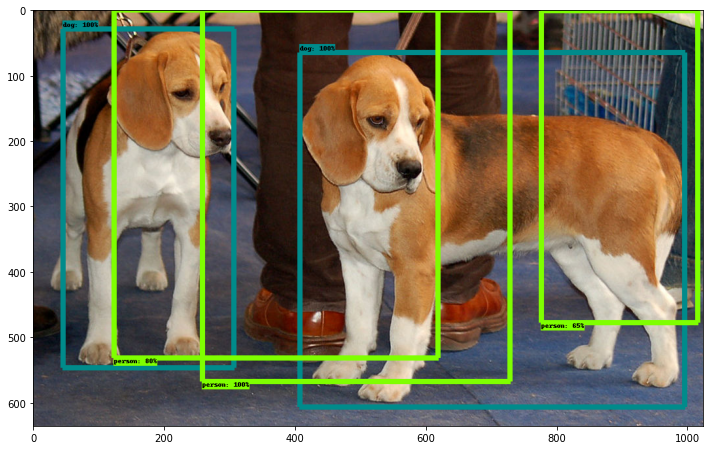

(900, 1352, 3)


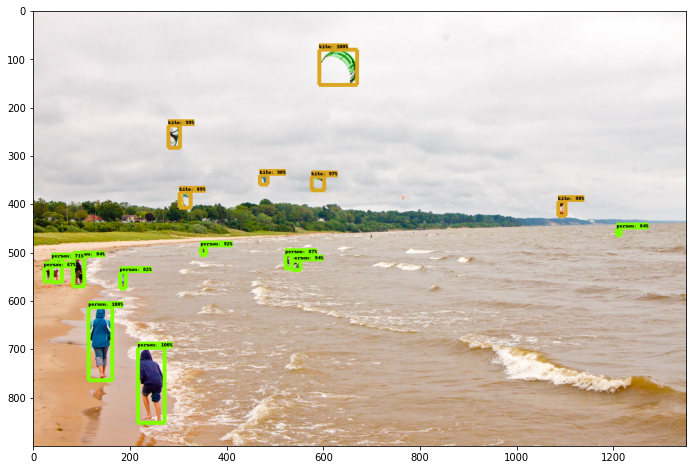

(347, 520, 3)


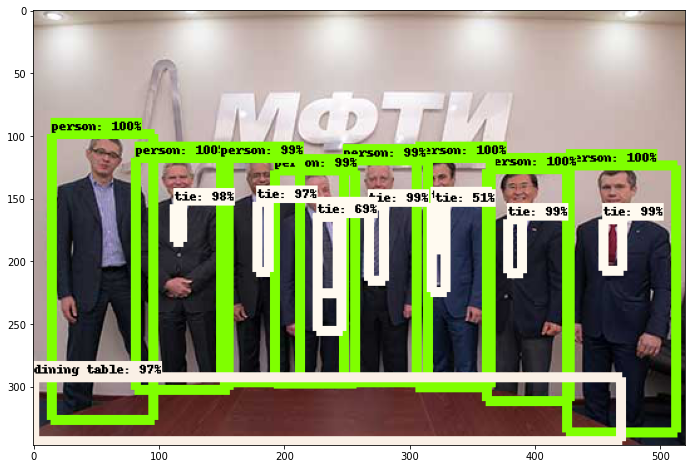

In [63]:
for image_path in TEST_IMAGE_PATHS:
    
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    print(image_np.shape)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    # Visualization of the results of a detection
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    
    plt.figure(figsize=IMAGE_SIZE)
    
    plt.imshow(image_np)
    plt.show()

In [46]:
!pwd 

/content/models/research/object_detection


На самом деле, TensorFlow -- это не только библиотека для написания нейросетей, есть ещё много модулей для самых разных целей, а именно:

* [TensorFlow.js](https://js.tensorflow.org/) -- использование нейронок в браузере
* [TensorFlow Slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) -- много готовых слоёв и кода, который делает обучение сеток более удобным и быстрым процессом
* [TensorFlow Serving](https://www.tensorflow.org/serving/) -- модуль, чтобы удобнее было выводить свои нейронки в продакшн (деплоить их)
* [TensorFlow Hub](https://www.tensorflow.org/hub/) -- хранилище готовых моделей
* [TensorFlow Lite](https://www.tensorflow.org/lite/) -- чтобы творить deep learning на мобильных устройствах

---

Отлично, мы научились детектировать объекты с TF Object Detection API, НО - - если Вы попробуете просто указать вместо текущей модели какое-то другое имя из зоопарка детекторов, то он выдаст ошибку. Как её избежать? 

### Mask R-CNN

Mask R-CNN можно так же запустить из TF Object Detection API. Давайте сделаем это!

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

In [ ]:
# !wget http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz

Ещё хорошая реализация Mask R-CNN на Keras есть в [этом репозитоии](https://github.com/matterport/Mask_RCNN)

### YOLOv3

Осталось научиться запускать YOLOv3, и тогда можно считать, что мы победили.

Один из гитхабов с реализацией YOLOv3: https://github.com/ayooshkathuria/pytorch-yolo-v3

In [ ]:
В домашнем задании!

Ещё хорошие варианты: https://github.com/akozd/tensorflow_yolo_v3 и https://github.com/maiminh1996/YOLOv3-tensorflow 

### Полезные ссылки

#### Введение

Отличная статья-введение в object detection: https://medium.com/comet-app/review-of-deep-learning-algorithms-for-object-detection-c1f3d437b852

#### Данные

PASCAL VOC датасет: http://host.robots.ox.ac.uk/pascal/VOC/ 

MS COCO датасет: http://cocodataset.org/#home

Скрипт для перевода разметки на VOC в разметку на COCO: https://github.com/soumenpramanik/Convert-Pascal-VOC-to-COCO/blob/master/convertVOC2COCO.py

Google Open Images датасет: https://storage.googleapis.com/openimages/web/index.html

EPIC Kithens: https://epic-kitchens.github.io/2018

Датасет для детектирования и сегментации типов одежды: https://github.com/eBay/modanet

#### Списки

Исчерпывающий список нейросетевых детекторов с их кодом: https://github.com/amusi/awesome-object-detection

#### Сравнение детекторов друг с другом

Статья про сравнение нейросетевых детекторов: https://arxiv.org/pdf/1611.10012.pdf 

#### YOLOv3

Сайт разработчика YOLO: https://pjreddie.com/darknet/yolo/

Статьи: [YOLO](), [YOLOv2](), [YOLOv3]()

Туториал по написанию своего YOLOv3: https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/

Русскоязычная статья на Хабре: https://habr.com/company/dataart/blog/350120/

#### Single Shot Multibox Detector (SSD)

Статья: https://arxiv.org/abs/1512.02325

[Статья-туториал](https://medium.com/@jonathan_hui/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06)

Реализация на PyTorch: https://github.com/amdegroot/ssd.pytorch

Реализация на Keras: https://github.com/rykov8/ssd_keras

#### Faster-RCNN

Статья: https://arxiv.org/pdf/1506.01497.pdf

Реализация на PyTorch: https://github.com/jwyang/faster-rcnn.pytorch

#### Tensorflow Object Detection API

Главный репозиторий: https://github.com/tensorflow/models/tree/master/research/object_detection

Запуск на Windows: https://medium.com/@rohitrpatil/how-to-use-tensorflow-object-detection-api-on-windows-102ec8097699

#### Объяснение метрики mAP

Раз: https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Два: https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

#### Соревнования

2-ое место на Google Open Images датасете: https://arxiv.org/abs/1809.00778 

#### Ещё

Object Detection с помощью OpenCV: https://www.pyimagesearch.com/2017/09/11/object-detection-with-deep-learning-and-opencv/

Реализации *-RCNN от Facebook (на Caffe): https://github.com/facebookresearch/Detectron

Реализации детекторов на PyTorch: https://github.com/ignacio-rocco/detectorch

Инструмент для разметки боксов: https://github.com/tzutalin/labelImg

